# BT4222 Assignment 3
By Teo Zhi Feng (A0203989N)

# 1 Setup

#### Import packages

In [1]:
from __future__ import print_function

from numpy.random import seed
from tensorflow.random import set_seed

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D, LSTM, MaxPooling1D, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import string
import re

#### Determine parameters

In [2]:
epochs = 10
batch_size = 128 # Select a batch size to fully utilise GPU memory, or 16 or 32

embedding_dims = 50 # emddeding for each word
maxlen = 800 # max number of words in the review

filters = 250
kernel_size = 3 # size of the 1D conv. layer
hidden_dims = 128 # number of dimensions

metrics = ['accuracy', "Precision", "Recall"]

#### Helper function to extract and store results

In [3]:
results = {}

In [4]:
def get_results(metrics, name, results=results, store=False):
  loss = round(metrics[0], 3)
  accuracy = round(metrics[1], 3)
  precision = round(metrics[2], 3)
  recall = round(metrics[3], 3)
  f1 = round( 2*((precision * recall) / (precision + recall)), 3 )
  print('Model performance on {}:\n Loss: {}\n Accuracy: {}\n Precision: {}\n Recall: {}\n F1: {}'.format(name, loss, accuracy, precision, recall, f1))
  if store == False: results = results.copy()
  results[name] = {'Loss': loss, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
      'F1': f1} 
  return pd.DataFrame(results)

#### Import IMDB Dataset

In [5]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.9M      0  0:00:05  0:00:05 --:--:-- 15.5M


In [6]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [7]:
!rm -r aclImdb/train/unsup

#### Import all datasets

In [8]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 157
Number of batches in raw_val_ds: 40
Number of batches in raw_test_ds: 196


#### Inspect dataset

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I gave this a four purely out of its historical context. It was considered lost for many years until it popped up out of the blue on Showtime in the early nineties.<br /><br />Moe is the straight man and Larry and Curly act as a duo. Spade Cooley has a couple of numbers. I guess it had something to do with working on a ranch. I'm not quite sure because the plot was so minimal nothing really sticks in my memory. I vaguely remember it being a western musical comedy. Even the Stooge's seem to be going through the motions. Overall there's nothing much really to recommend here.<br /><br />If you're not a Stooge fan then don't bother. If you are a Stooge fan, then stick with the shorts."
0
b'First than anything, I\'m not going to praise I\xc3\xb1arritu\'s short film, even I\'m Mexican and proud of his success in mainstream Hollywood.<br /><br />In another hand, I see most of the reviews focuses on their favorite (and not so) short films; but we are forgetting that there is a subtle bottom 

# 2 Data Pre-Processing

#### Vectorise data

In [10]:
# Define custom function
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Model constants.
max_features = 20000

# Instantiate text vectorisation layer to normalize, split, and map strings to integers.
# We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=maxlen,
)

# With vocab layer, call `adapt` on a text-only dataset to create the vocabulary. 
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [11]:
print(len(vectorize_layer.get_vocabulary()))
print(vectorize_layer.get_vocabulary()[:20])

20000
['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']


In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

#### Inspect vectorised dataset

In [13]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'OK, so the musical pieces were poorly written and generally poorly sung (though Walken and Marner, particularly Walken, sounded pretty good). And so they shattered the fourth wall at the end by having the king and his nobles sing about the "battle" with the ogre, and praise the efforts of Puss in Boots when they by rights shouldn\'t have even known about it.<br /><br />Who cares? It\'s Christopher Freakin\' Walken, doing a movie based on a fairy tale, and he sings and dances. His acting style fits the role very well as the devious, mischievous Puss who seems to get his master into deeper and deeper trouble but in fact has a plan he\'s thought about seven or eight moves in advance. And if you\'ve ever seen Walken in any of his villainous roles, you *know* the ogre bit the dust HARD at the end when Walken got him into his trap.<br /><br />A fun film, and a must-see for anyone who enjoys the unique style of Christopher Walken.', shape=(), dtype=string)
Label pos
Vectori

# 3 Convolutional Neural Network (CNN)

#### Build model

In [14]:
# Define model
model_cnn = Sequential()
model_cnn.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Convolutional layer 1
model_cnn.add(Conv1D(filters, kernel_size, padding='same', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
# Flatten before connecting to dense layer 
model_cnn.add(Flatten())
model_cnn.add(Dense(hidden_dims, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid', name='predictions'))
# Use binary_crossentropy loss function as it is a binary classification problem 
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [15]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 50)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 800, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 1

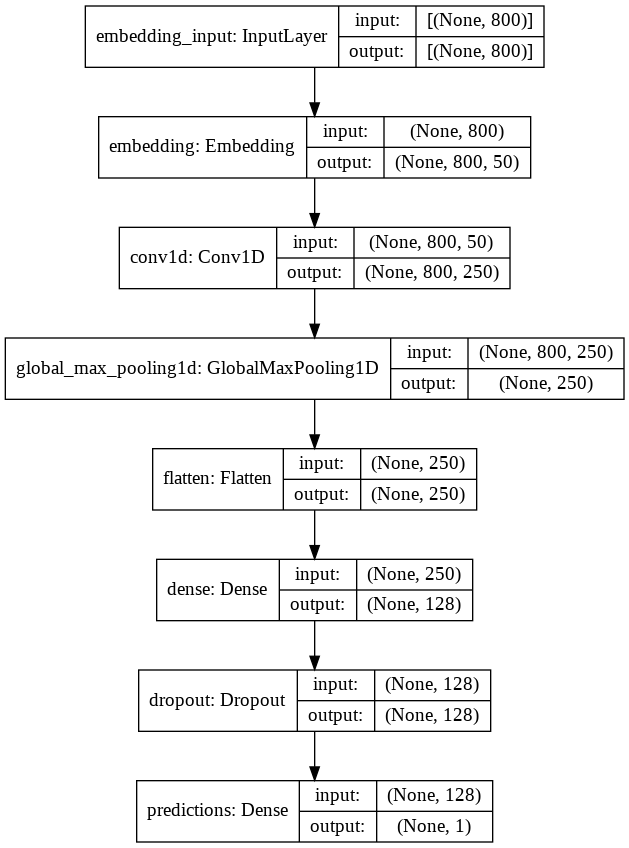

In [16]:
plot_model(model_cnn, show_shapes=True)

#### Train model using train dataset

In [17]:
# Fit model using train dataset
history_cnn = model_cnn.fit(train_ds, epochs=epochs, verbose = 1, batch_size=batch_size, validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/10
157/157 [==============================] - 13s 66ms/step - loss: 0.5471 - accuracy: 0.6955 - precision: 0.6977 - recall: 0.6873 - val_loss: 0.3508 - val_accuracy: 0.8440 - val_precision: 0.8436 - val_recall: 0.8483
Epoch 2/10
157/157 [==============================] - 9s 57ms/step - loss: 0.2632 - accuracy: 0.8943 - precision: 0.8889 - recall: 0.9008 - val_loss: 0.2740 - val_accuracy: 0.8846 - val_precision: 0.8874 - val_recall: 0.8835
Epoch 3/10
157/157 [==============================] - 9s 56ms/step - loss: 0.1423 - accuracy: 0.9503 - precision: 0.9485 - recall: 0.9522 - val_loss: 0.3338 - val_accuracy: 0.8740 - val_precision: 0.8300 - val_recall: 0.9437
Epoch 4/10
157/157 [==============================] - 9s 56ms/step - loss: 0.0668 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9813 - val_loss: 0.3366 - val_accuracy: 0.8828 - val_precision: 0.8955 - val_recall: 0.8693
Epoch 5/10
157/157 [==============================] - 9s 57ms/step - loss: 0.0312 - accuracy: 0.990

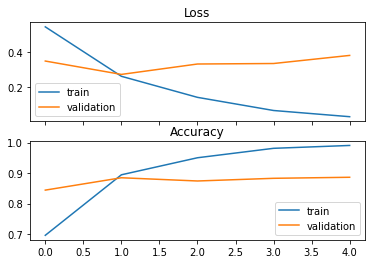

In [18]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_cnn.history['loss'], label='train')
axis[0].plot(history_cnn.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_cnn.history['accuracy'], label='train')
axis[1].plot(history_cnn.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [19]:
metrics_cnn = model_cnn.evaluate(test_ds,verbose=1)

196/196 [==============================] - 7s 36ms/step - loss: 0.4016 - accuracy: 0.8807 - precision: 0.8702 - recall: 0.8949


In [20]:
get_results(metrics_cnn, 'CNN', store=True)

Model performance on CNN:
 Loss: 0.402
 Accuracy: 0.881
 Precision: 0.87
 Recall: 0.895
 F1: 0.882


,CNN
Accuracy,0.881
F1,0.882
Loss,0.402
Precision,0.870
Recall,0.895


# 4 Long Short-Term Memory (LSTM) 

#### Build model

In [22]:
# Define model
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# LSTM layer
model_lstm.add(LSTM(120, return_sequences=True))
model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(Dense(1, activation='sigmoid', name='predictions'))
# Compile
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [23]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 50)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 800, 120)          82080     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 121       
Total params: 1,082,201
Trainable params: 1,082,201
Non-trainable params: 0
_________________________________________________________________


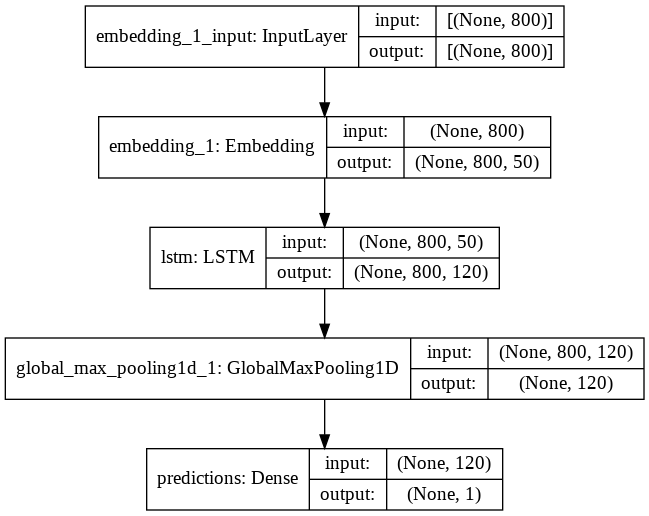

In [24]:
plot_model(model_lstm, show_shapes=True)

#### Train model using train dataset

In [25]:
# Fit model using train dataset
history_lstm = model_lstm.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/10
157/157 [==============================] - 31s 179ms/step - loss: 0.5955 - accuracy: 0.7013 - precision: 0.6678 - recall: 0.7986 - val_loss: 0.4536 - val_accuracy: 0.8140 - val_precision: 0.7691 - val_recall: 0.9025
Epoch 2/10
157/157 [==============================] - 27s 174ms/step - loss: 0.3366 - accuracy: 0.8707 - precision: 0.8623 - recall: 0.8816 - val_loss: 0.3126 - val_accuracy: 0.8722 - val_precision: 0.8712 - val_recall: 0.8764
Epoch 3/10
157/157 [==============================] - 27s 173ms/step - loss: 0.1855 - accuracy: 0.9309 - precision: 0.9268 - recall: 0.9354 - val_loss: 0.3386 - val_accuracy: 0.8724 - val_precision: 0.8661 - val_recall: 0.8839
Epoch 4/10
157/157 [==============================] - 27s 174ms/step - loss: 0.1148 - accuracy: 0.9632 - precision: 0.9622 - recall: 0.9640 - val_loss: 0.4214 - val_accuracy: 0.8698 - val_precision: 0.8668 - val_recall: 0.8768
Epoch 5/10
157/157 [==============================] - 27s 174ms/step - loss: 0.0814 - accura

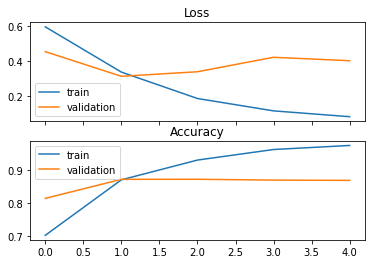

In [26]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_lstm.history['loss'], label='train')
axis[0].plot(history_lstm.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_lstm.history['accuracy'], label='train')
axis[1].plot(history_lstm.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [27]:
metrics_lstm = model_lstm.evaluate(test_ds,verbose=1)

196/196 [==============================] - 11s 54ms/step - loss: 0.4651 - accuracy: 0.8527 - precision: 0.8736 - recall: 0.8246


In [28]:
get_results(metrics_lstm, 'LSTM', store=True)

Model performance on LSTM:
 Loss: 0.465
 Accuracy: 0.853
 Precision: 0.874
 Recall: 0.825
 F1: 0.849


,CNN,LSTM
Loss,0.402,0.465
Accuracy,0.881,0.853
Precision,0.870,0.874
Recall,0.895,0.825
F1,0.882,0.849


# 5 Model Comparison
The results are summarised in the DataFrame below.

In [30]:
pd.DataFrame(results)

,CNN,LSTM
Loss,0.402,0.465
Accuracy,0.881,0.853
Precision,0.870,0.874
Recall,0.895,0.825
F1,0.882,0.849


From the results, we see that CNN performed better than LSTM, achieving a higher accuracy (0.886 vs 0.853), precision (0.885 vs 0.822), and F1 scores (0.887 vs 0.859). Recall scores are comparable for both models. 

We see that CNN performed better than LSTM. This is likely because whether a review is negative or positive can be determined by a window of local features, something that CNN can more accurately identify.

On the other hand, the sequential and hence contextual information that RNN can identify may not be as significant in this sentiment analysis. Furthermore, there is a higher risk of bias and hence overfitting when using LSTM.

Comments on CNN:
1. CNN is useful to recognise patterns across space as it extracts local and position-invariant features.
3. CNN is computationally faster as it allows for parallelization over every element in the word sequence.
4. CNN is better when feature detection in text is more important but it is difficult to obtain contextual information.

Comments on LSTM/RNN:
1. LSTM/RNN is useful to recognise patterns across time as it captures long-term dependencies between word sequences.
2. LSTM/RNN is ideal for sequential data when the current step is related with the previous steps or datasets with a time component. 
3. LSTM/RNN is better when sequential modeling is more important but the order of words can lead to bias. 

# 6 Deeper Insights
To explore further, I looked into 6 different insights which can affect model performance.
1. Different word embedding techniques 
2. Wide vs deep network
3. Different CNN/LSTM models
4. Different activation functions in intermediate layers

#### Insight 1: Different word embedding techniques 
Different word embedding techniques may affect the model performances. Other types of word embedding techniques could have been used, such as word2vec, which may have affected the model performances.

#### Insight 2: Wide vs deep neural network

Deep neural network (4 layers of CNN followed by 3 fully connected layers): \\
A wider but shallower model seems to work better for this dataset. The higher loss for the following deep network seems to suggest overfitting.


In [42]:
# Define model
model_deep = Sequential()
model_deep.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Convolutional layer
model_deep.add(Conv1D(filters, kernel_size, padding='same', activation='relu', strides=1))
model_deep.add(MaxPooling1D(pool_size=2))
# More convolutional layers
for i in range(3):
  model_deep.add(Conv1D(filters, kernel_size, padding='same', activation='relu', strides=1))
  model_deep.add(MaxPooling1D(pool_size=2))
model_deep.add(Flatten())
# Fully connected layer
model_deep.add(Dense(embedding_dims, activation='relu'))
model_deep.add(Dropout(0.5))
model_deep.add(Dense(1, activation='sigmoid', name='predictions'))
# Compile
model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [43]:
# Fit and evaluate
history_deep = model_deep.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_deep = model_deep.evaluate(test_ds,verbose=1)

196/196 [==============================] - 10s 52ms/step - loss: 0.6931 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00


In [44]:
# Compare results
get_results(metrics_deep, 'CNN (Deep)')

ZeroDivisionError: ignored

#### Insight 3: Different CNN/LSTM models
Different scholars have tried different combinations of CNN and LSTM layers in order to improve model performance. I will attempt two variations and compare their performaces.

Variation 1: LSTM + CNN

In [40]:
# Define model
model_lstm_cnn = Sequential()
model_lstm_cnn.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# LSTM layer
model_lstm_cnn.add(LSTM(120, return_sequences=True))
# Convolutional layer
model_lstm_cnn.add(Conv1D(filters, kernel_size, padding='same', activation='relu', strides=1))
model_lstm_cnn.add(GlobalMaxPooling1D())
model_lstm_cnn.add(Flatten())
# Fully connected layer
model_lstm_cnn.add(Dense(hidden_dims, activation='relu'))
model_lstm_cnn.add(Dropout(0.5))
model_lstm_cnn.add(Dense(1, activation='sigmoid', name='predictions'))
# Complie
model_lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [41]:
# Fit and evaluate
history_lstm_cnn = model_lstm_cnn.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, verbose = 0,
                                      callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_lstm_cnn = model_lstm_cnn.evaluate(test_ds,verbose=1)

KeyboardInterrupt: ignored

In [ ]:
# Store results
get_results(metrics_cnn_lstm, 'LSTM & CNN')

Variation 2: Bi-directional LSTM \\
Bi-directional LSTM performed significantly better than LSTM, yet not as well as CNN.

In [ ]:
# Define model
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# Bi-directional LSTM
model_bilstm.add(Bidirectional(LSTM(120, return_sequences = True)))
model_bilstm.add(GlobalMaxPooling1D())
model_bilstm.add(Flatten())
# Fully connected layer
model_bilstm.add(Dense(hidden_dims, activation='relu'))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Dense(1, activation='sigmoid', name='predictions'))
# Compile 
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [ ]:
# Fit and evaluate
history_bilstm = model_bilstm.fit(train_ds, epochs=epochs, verbose = 0,
                                      batch_size=batch_size, validation_data=val_ds,
                                      callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
metrics_bilstm = model_bilstm.evaluate(test_ds,verbose=0)

In [ ]:
# Store results
get_results(metrics_bilstm, 'Bi-Dir LSTM')

#### Insight 4: Different activation functions in intermediate layers

In [ ]:
activations = ['sigmoid', 'tanh']
results_insight4 = {}
results_insight4['CNN with Relu'] = results['CNN']

for active in activations:
  # Define model
  model_active = Sequential()
  model_active.add(Embedding(max_features, embedding_dims, input_length=maxlen))
  # Convolutional layer
  model_active.add(Conv1D(filters, kernel_size, padding='same', activation=active, strides=1))
  model_active.add(GlobalMaxPooling1D())
  model_active.add(Flatten())
  # Fully connected layer
  model_active.add(Dense(hidden_dims, activation=active))
  model_active.add(Dropout(0.5))
  model_active.add(Dense(1, activation='sigmoid', name='predictions'))
  # Compile and fit
  model_active.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
  history_active = model_active.fit(train_ds, epochs=epochs, verbose = 0,
                                        batch_size=batch_size, validation_data=val_ds,
                                        callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])
  metrics_active = model_active.evaluate(test_ds,verbose=0)
  # Store results
  get_results(metrics_active, 'CNN_'+str(active))